# Assignment Specs

- You should compare Neural Networks as we discussed this week to at least one of our previous models from this quarter.
- A secondary goal of this assignment is to test the effects of the neural network function(s) arguments on the algorithm's performance. 
    - You should explore at least 5 different sets of settings for the function inputs, and you should do your best to find values for these inputs that actually change the results of your modelling. That is, try not to run three different sets of inputs that result in the same performance. The goal here is for you to better understand how to set these input values yourself in the future. Comment on what you discover about these inputs and how the behave.
    - Additionally, I'd like you to include pictures of the network architecture for each of the neural network models you run. You may hand-draw them and insert pictures into your submitted files if you wish. You may also use software (e.g. draw.io) to create nice looking diagrams. I want you to become intimately familiar with these types of models and what they look like.
- Your submission should be built and written with non-experts as the target audience. All of your code should still be included, but do your best to narrate your work in accessible ways.

# Notes
- Neural networks are highly parameterized models inspired by the human brain so you need a good amount of training data.
- Deep learning is a neural network with more hidden layers.
- Tuning Parameters:
    - Number of hidden layers (> 1 for deep learning)
    - Number of units in each hidden layer
    - Starting values for the weights
    - Choice of regularization
    - Choice of stopping time (A stopper for iterative updating)
    - Choice of non-linearities (the form of the g function)(Activation function)
        - Sigmoid
        - Tanh
        - Step function
        - ReLU (Most used for Deep Learning)
        - Leaky ReLU (Variation that allows for negative values)
        - ELU (alpha 1.0) (Another variation that can outperform leaky)
    - Sigmoid and tanh are better than the simple step function...they’re differentiable and smooth
    - However, sigmoid and tanh asymptotically approach their saturation values (0 or 1, and -1 or 1 respectively)..
        - A saturated neural network is one where most of the hidden nodes have values close to these values
        - If hidden nodes are saturated that means their pre-activation sum-of-products is relatively large or small
        - This leads to a situation where a small change in the input-to-hidden weights during training will likely not change the sum-of-products very much....i.e. training stalls our or moves very slowly
        - Additionally, saturated models are often overfitted
    - A solution: Use other activation functions like ReLU (Rectified Linear Unit) defined as f (x) = max(0, x)
    
- To many weights can lead to overfitting and a global minimum of the loss
- **Current wisdom:** 
    - Better to have large number of hidden units (5 to 100), compared to hidden layers.
    - Control model complexity with regularization (cross-validation).
        - Regularization slows the rate of overfitting.
    - More hidden layers increases complexity, but tends to be task specific.
    - Stopping time can also be determined with cross-validation, but is less of a problem with regularization.
    - Choice of starting weight values can affect movement of the algorithm and where it ends up: (Default should work fine)
        - Shouldn’t be zero
        - Shouldn’t be large
        - Try multiple sets
    - For quantitative regression, h is typically the identity.
    - For classification, h is once again the sigmoid.

# Import Data

In [56]:
import pandas as pd
import numpy as np

wine = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week4/wine/cleansingWine.csv")
wine.head()

/var/folders/jl/kkh608tn0k194f6cv0bwbqp80000gn/T/ipykernel_96553/130984684.py:3: DtypeWarning: Columns (8,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  wine = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week4/wine/cleansingWine.csv")


,Unnamed: 0,id,name,producer,nation,local1,local2,local3,local4,varieties1,...,use,abv,degree,sweet,acidity,body,tannin,price,year,ml
0,0,137197,Altair,Altair,Chile,Rapel Valley,NaN,NaN,NaN,Cabernet Sauvignon,...,Table,14~15,17~19,SWEET1,ACIDITY4,BODY5,TANNIN4,220000,2014,750
1,1,137198,"Altair, Sideral",Altair,Chile,Rapel Valley,NaN,NaN,NaN,Cabernet Sauvignon,...,Table,14~15,16~18,SWEET1,ACIDITY3,BODY4,TANNIN4,110000,2016,750
2,2,137199,Baron du Val Red,Baron du Val,France,NaN,NaN,NaN,NaN,Carignan,...,Table,11~12,15~17,SWEET2,ACIDITY3,BODY2,TANNIN2,0,0,750
3,3,137200,Baron du Val White,Baron du Val,France,NaN,NaN,NaN,NaN,Carignan,...,Table,11~12,9~11,SWEET1,ACIDITY3,BODY2,TANNIN1,0,0,750
4,4,137201,"Benziger, Cabernet Sauvignon",Benziger,USA,California,NaN,NaN,NaN,Cabernet Sauvignon,...,Table,13~14,17~19,SWEET1,ACIDITY3,BODY3,TANNIN4,0,2003,750


# Clean Process

In [57]:
wine_clean = wine.copy()
# Remove wine prices that are zero or greater than 100k
wine_clean = wine_clean[wine_clean["price"] > 0]
wine_clean = wine_clean[wine_clean["price"] < 100000]


# Remove columns with lots of NaNs
# Define a threshold and drop columns with more than 50% missing
threshold = 0.47
missing_fraction = wine_clean.isnull().mean()
columns_to_drop = missing_fraction[missing_fraction > threshold].index
wine_clean.drop(columns=columns_to_drop, inplace=True)

# Drop Remaining Nans
wine_clean.dropna(inplace=True)
wine_clean.head()

,Unnamed: 0,id,name,producer,nation,local1,varieties1,type,use,abv,degree,sweet,acidity,body,tannin,price,year,ml
7,7,137204,"Calvet, Bordeaux Red",Calvet,France,Bordeaux,Merlot,Red,Table,13~14,16~18,SWEET1,ACIDITY3,BODY2,TANNIN3,21000,2011,750
8,8,137205,"Calvet, Bordeaux white",Calvet,France,Bordeaux,Sauvignon blanc,White,Table,11.5,9~11,SWEET1,ACIDITY4,BODY2,TANNIN1,21000,2010,750
9,9,137207,"Calvet, Varietals Cabernet Sauvignon",Calvet,France,Southern France,Cabernet Sauvignon,Red,Table,13~14,16~18,SWEET1,ACIDITY3,BODY2,TANNIN3,19000,2017,750
10,10,137208,"Calvet, Varietals Merlot",Calvet,France,Southern France,Merlot,Red,Table,13~14,16~18,SWEET1,ACIDITY3,BODY3,TANNIN3,19000,2011,750
11,11,137209,"Calvet, Reserve Bordeaux white",Calvet,France,Bordeaux,Sauvignon blanc,White,Table,11.5,9~11,SWEET1,ACIDITY4,BODY2,TANNIN1,28000,2011,750


# Modeling Process
## Data prep for model

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Price as predictor
X = wine_clean.drop(columns=["price"])
y = wine_clean["price"]

# Satisfy categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Train model

In [59]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create the model
nn = MLPRegressor(
    hidden_layer_sizes=(64, ),    # One hidden layer with 64 neurons
    activation='logistic',        # Activation function: relu, tanh, logistic(Sigmoid)
    solver='adam',                # Optimizer: adam(use unless specific reason not to), sgd(smaller datasets), lbfgs(very specific tuning)
    alpha=0.001,                  # L2 regularization (like ridge)
    learning_rate='adaptive',     # Learning rate schedule: constant(Can lead to overshoot), invscaling(Decreases for conversion)
    max_iter=500,                 # Number of training iterations
    early_stopping=True,          # Will stop if validation score stops improving
    n_iter_no_change=50,          # Number of iterations to wait before stopping
    random_state=42
)

# Fit the model
nn.fit(X_train_scaled, y_train)

# Predict
y_pred = nn.predict(X_test_scaled)

# Evaluate
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MSE: 3043116669.068638
R²: -4.885685082460717


In [65]:
print("Prediction Std Dev:", np.std(y_pred))
print("\nFirst 10 predictions:", y_pred[:10])
print("\nFirst 10 actual:", y_test[:10].values)

Prediction Std Dev: 1886.5796250933404

First 10 predictions: [ 278.1226158  4000.19504018   23.81746194    8.8810095   201.16498161
 1996.57781125 2038.28262673  231.80721832 4709.448707    769.59709173]

First 10 actual: [11.08214255 11.40756495 11.36210258 11.23848862 10.51867319 11.11988288
 10.59663473 11.00209984 10.49127422 10.77895629]


Note: Sigmoid activation for regression is not ideal:

- Sigmoid squashes output to between 0 and 1.
- Wine prices are probably much higher (e.g., 5–500+), so the model can’t reach them.
- That’s why it’s way off — causing high MSE and negative R².
    
If you’re going to use activation='logistic', you must scale the target (y) to the 0–1 range, like this:

In [60]:
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
y_train_scaled2 = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled2 = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# Use values from 0-1
nn.fit(X_train_scaled, y_train_scaled2)
y_pred_scaled = nn.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Evaluate using original scale
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 5926782357.976564
R²: -10.462976384014288


Here we can see that even with these changes we have bad scored due to logistic. Lets try ReLU

In [61]:
nn2 = MLPRegressor(
    hidden_layer_sizes=(16,),
    activation='relu',          # Using ReLU
    solver='adam',
    alpha=0.01,
    learning_rate='adaptive',
    early_stopping=True,
    n_iter_no_change=10,
    max_iter=500,
    random_state=42
)

nn2.fit(X_train_scaled, y_train)

y_pred2 = nn2.predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred2))
print("R²:", r2_score(y_test, y_pred2))


MSE: 3044547426.612845
R²: -4.888452307398279


In [62]:
print("Prediction Std Dev:", np.std(y_pred2))
print("\nFirst 10 predictions:", y_pred2[:10])
print("\nFirst 10 actual:", y_test[:10].values)

Prediction Std Dev: 1.0493749222145836

First 10 predictions: [2.15597234 3.60761141 1.95957004 3.04805119 2.75165512 3.43113096
 2.93003417 2.46181652 3.1198486  2.33775029]

First 10 actual: [65000 90000 86000 76000 37000 67500 40000 60000 36000 48000]


Again we are seeing these poor metrics. After looking at the standard deviation of the predictions we see that we get 28k. This compared to our actual range 0-100k is quite small and we are seeing the model predict negative prices as well. To fix let us use a log transformation to compress the range.

In [63]:
from sklearn.metrics import mean_absolute_error

wine_clean["log_price"] = np.log(wine_clean["price"])

X = wine_clean.drop(columns=["price", "log_price"])
y = wine_clean["log_price"]

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train nn
nn3 = MLPRegressor(
    hidden_layer_sizes=(64,),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='adaptive',
    early_stopping=True,
    n_iter_no_change=50,
    max_iter=500,
    random_state=42
)

nn3.fit(X_train_scaled, y_train)

# Predict
y_pred_log = nn3.predict(X_test_scaled)
y_pred = np.exp(y_pred_log)  # Convert back to original price scale
y_test_actual = np.exp(y_test)  # Compare on same scale

# 6. Evaluate
print("MSE:", mean_squared_error(y_test_actual, y_pred))
print("MAE:", mean_absolute_error(y_test_actual, y_pred)) #Less sensitive to outliers
print("R²:", r2_score(y_test_actual, y_pred))

MSE: 2881370735.6894975
MAE: 48614.18114955868
R²: -4.5728526377126615


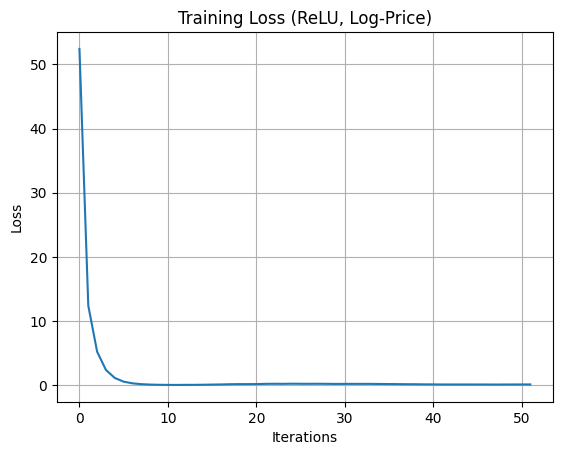

In [40]:
import matplotlib.pyplot as plt

plt.plot(nn.loss_curve_)
plt.title("Training Loss (ReLU, Log-Price)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()